In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from sklearn.neural_network import MLPRegressor

In [4]:
df = pd.read_csv("HousingData.csv")

print(df.shape)
print(df.columns.tolist())
print(df.head())

(506, 14)
['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90    NaN  36.2  


In [5]:
print(df.isnull().sum())

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64


In [6]:
X = df.drop(columns=['MEDV'])
y = df['MEDV']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape)
print(X_test.shape)

(404, 13)
(102, 13)


In [7]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

train_df = X_train_scaled.copy()
train_df['MEDV'] = y_train.values

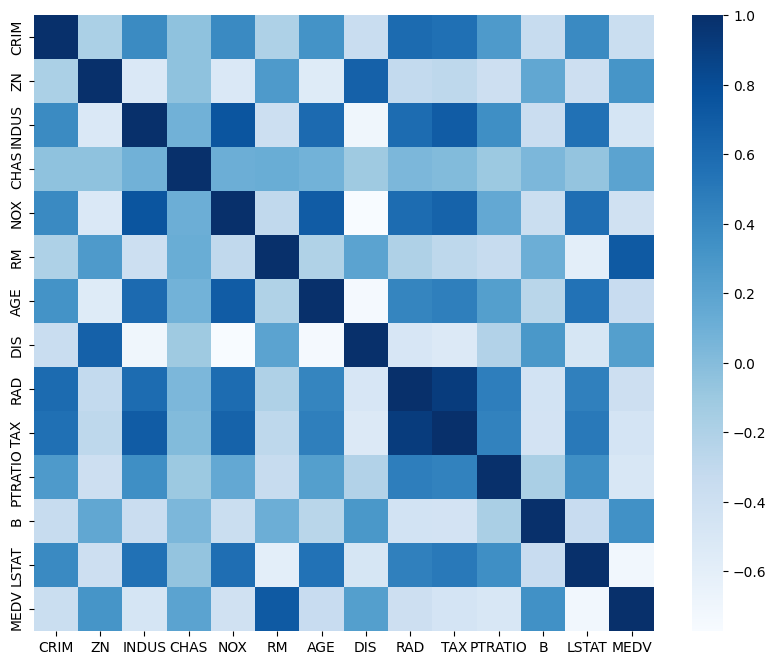

In [9]:
corr_matrix = train_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='Blues', annot=False)
plt.show()


In [10]:
target_corr = corr_matrix['MEDV'].drop('MEDV').sort_values(ascending=False)
print(target_corr)

RM         0.710680
B          0.339918
ZN         0.311411
DIS        0.235114
CHAS       0.198095
AGE       -0.344526
CRIM      -0.370670
RAD       -0.387467
NOX       -0.415768
TAX       -0.459795
INDUS     -0.461958
PTRATIO   -0.491210
LSTAT     -0.716669
Name: MEDV, dtype: float64


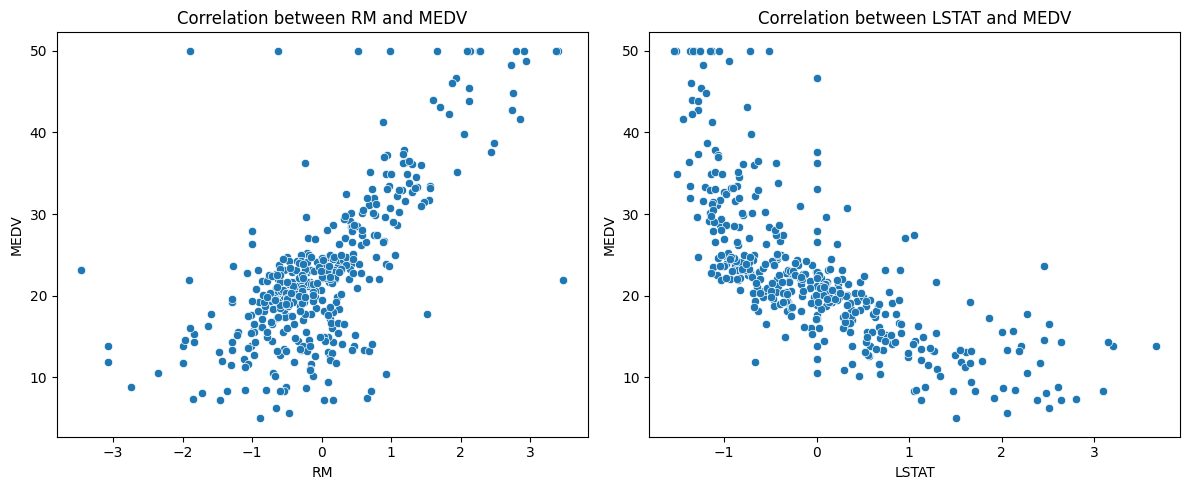

In [11]:

top2_features = ['RM', 'LSTAT']
plt.figure(figsize=(12, 5))
for i, feat in enumerate(top2_features):
    plt.subplot(1, 2, i+1)
    sns.scatterplot(x=train_df[feat], y=train_df['MEDV'])
    plt.title(f"Correlation between {feat} and MEDV")
plt.tight_layout()
plt.show()


In [12]:
X_train_2d = X_train_scaled[['RM', 'LSTAT']]
X_test_2d  = X_test_scaled[['RM', 'LSTAT']]

In [13]:
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 8, 4),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=False
)
mlp.fit(X_train_2d, y_train)

y_test_pred  = mlp.predict(X_test_2d)

from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_test, y_test_pred))

18.15041405140666


In [14]:
rm = np.linspace(X_train_2d['RM'].min(), X_train_2d['RM'].max(), 50)
ls = np.linspace(X_train_2d['LSTAT'].min(), X_train_2d['LSTAT'].max(), 50)
RM_grid, LS_grid = np.meshgrid(rm, ls)
grid = pd.DataFrame({'RM': RM_grid.ravel(), 'LSTAT': LS_grid.ravel()})
Z = mlp.predict(grid).reshape(RM_grid.shape)


fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=X_train_2d['RM'], y=X_train_2d['LSTAT'], z=y_train,
    mode='markers', marker=dict(size=5, color='steelblue', opacity=0.8),
    name='Train data'
))

fig.add_trace(go.Scatter3d(
    x=X_test_2d['RM'], y=X_test_2d['LSTAT'], z=y_test,
    mode='markers', marker=dict(size=6, color='crimson', symbol='diamond', opacity=0.9),
    name='Test data'
))

fig.add_trace(go.Surface(
    x=RM_grid, y=LS_grid, z=Z,
    colorscale='Viridis', opacity=0.7, name='MLP Surface',
    showscale=True
))

fig.update_layout(
    scene=dict(
        xaxis_title='RM',
        yaxis_title='LSTAT',
        zaxis_title='MEDV',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    width=1000, height=700,
    margin=dict(l=0, r=0, b=0, t=80)
)

fig.show()